# Library

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Collect data

In [ ]:
!pip install datasets
!git clone https://github.com/IndoNLP/nusa-crowd.git
!pip install nusacrowd

In [ ]:
from datasets import load_dataset

path = "nusa-crowd/nusacrowd/nusa_datasets/id_abusive"
dataset = load_dataset(path)

# see dataset sample:
df = dataset['train'].to_pandas()

/usr/local/lib/python3.10/dist-packages/datasets/load.py:929: FutureWarning: The repository for id_abusive contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at nusa-crowd/nusacrowd/nusa_datasets/id_abusive/id_abusive.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [ ]:
df

,tweet,label
0,- Dia sendiri yang ngiklanin promo cashback di...,abusive
1,- disaat semua cowok berusaha melacak perhatia...,abusive_and_offensive
2,- kampret kan kalo typo-nya di email kantor ke...,abusive
3,"- Mending makan disini lebih murah, buang-buan...",abusive
4,/biarin oppa masukim vibrator ke memek/ oppa k...,abusive
...,...,...
2011,Yagimanasih anjir gue dirumah doang dari pagi ...,abusive
2012,Yah sekian pandangan awam dari saya wkwwk seka...,not_abusive
2013,yang butuh memek hubungi rp haneul terdekat',abusive
2014,Yang sabar gua mah punya adek2 kunyuk yg bau k...,abusive


In [ ]:
df['label'].unique()
df.label.value_counts()

label
abusive                  1090
abusive_and_offensive     595
not_abusive               331
Name: count, dtype: int64

# Pre-processing

In [ ]:
def clean_text(tweet):
    tweet = cleaned_text = ''.join(char for char in tweet if ord(char) < 128)
    # Menghapus RT tag
    t1 = re.sub('RT\s', '', tweet)
    # Menghapus @_username
    t2 = re.sub(r'\@([\w]+)',' ', t1)
    # Mengganti emoji decode dengan spasi
    t3 = re.sub(r'\\u[a-zA-Z0-9]{4}', ' ', t2)
    # Mengganti enter /n/ dengan spasi
    t4 = re.sub('\n\s', ' ', t3)
    t5 = re.sub('\n', ' ', t4)
    # Non-ascii
    t6 = re.sub(r'[^\x00-\x7F]+',' ', t5)
    # Koreksi duplikasi tiga karakter beruntun atau lebih (contoh. yukkk)
    t7 = re.sub(r'([a-zA-Z])\1\1','\\1', t6)
    # Replace URL
    t8 = re.sub(r'http[s]?\:\/\/.[a-zA-Z0-9\.\/\_?=%&#\-\+!]+',' ', t7)
    t9 = re.sub(r'pic.twitter.com?.[a-zA-Z0-9\.\/\_?=%&#\-\+!]+',' ', t8)
    # Konversi ke karakter huruf kecil
    t10 = t9.lower()
    # Hapus tagar
    t11 = re.sub(r'\#[a-zA-Z0-9_]+','', t10)
    # Hapus angka
    t12 = re.sub(r'[0-9]+',' ', t11)
    # Hapus simbol
    t13 = re.sub(r'[!$%^&*@#()_+|~=`{}\[\]%\-:";\'<>?,.\/]', ' ', t12)
    # Spasi ganda (atau lebih) menjadi satu spasi
    t14 = re.sub(' +', ' ', t13)
    # Spasi di awal dan akhir kalimat
    t15 = re.sub(r'^[ ]|[ ]$','', t14)
    # Menghilangkan karakter \xf, \x, f\x, \x
    t16 = re.sub(r'\\\\x[a-fA-F0-9]{0,2}|\\\\x|\\xf|\\x', '', t15)
    # Menghapus kata "user" (bisa disesuaikan dengan kata-kata lain)
    t17 = re.sub(r'\buser\b', '', t16, flags=re.IGNORECASE)
    # Menghilangkan karakter non-ASCII dan karakter spesial
    t18 = re.sub(r'[^\x00-\x7F]+', ' ', t17)
    # Menghapus whitespace ekstra
    t19 = re.sub(r'\s+', ' ', t18)
    return t19.strip()

for i, r in df.iterrows():
    y = clean_text(r['tweet'])
    df.loc[i, 'tweet'] = y
df

,tweet,label
0,dia sendiri yang ngiklanin promo cashback di a...,abusive
1,disaat semua cowok berusaha melacak perhatian ...,abusive_and_offensive
2,kampret kan kalo typo nya di email kantor keti...,abusive
3,mending makan disini lebih murah buang buang d...,abusive
4,biarin oppa masukim vibrator ke memek oppa kok...,abusive
...,...,...
2011,yagimanasih anjir gue dirumah doang dari pagi ...,abusive
2012,yah sekian pandangan awam dari saya wkwwk seka...,not_abusive
2013,yang butuh memek hubungi rp haneul terdekat,abusive
2014,yang sabar gua mah punya adek kunyuk yg bau ke...,abusive


In [ ]:
df['tweet'] = df['tweet'].apply(word_tokenize)
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatizer(text):
  lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
  return lemm_text

df['tweet']=df['tweet'].apply(lambda x:lemmatizer(x))
df

,tweet,label
0,"[dia, sendiri, yang, ngiklanin, promo, cashbac...",abusive
1,"[disaat, semua, cowok, berusaha, melacak, perh...",abusive_and_offensive
2,"[kampret, kan, kalo, typo, nya, di, email, kan...",abusive
3,"[mending, makan, disini, lebih, murah, buang, ...",abusive
4,"[biarin, oppa, masukim, vibrator, ke, memek, o...",abusive
...,...,...
2011,"[yagimanasih, anjir, gue, dirumah, doang, dari...",abusive
2012,"[yah, sekian, pandangan, awam, dari, saya, wkw...",not_abusive
2013,"[yang, butuh, memek, hubungi, rp, haneul, terd...",abusive
2014,"[yang, sabar, gua, mah, punya, adek, kunyuk, y...",abusive


In [ ]:
df_cleaned = df.dropna()

In [ ]:
def text_process(tweet):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in tweet if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)

    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('indonesian')]

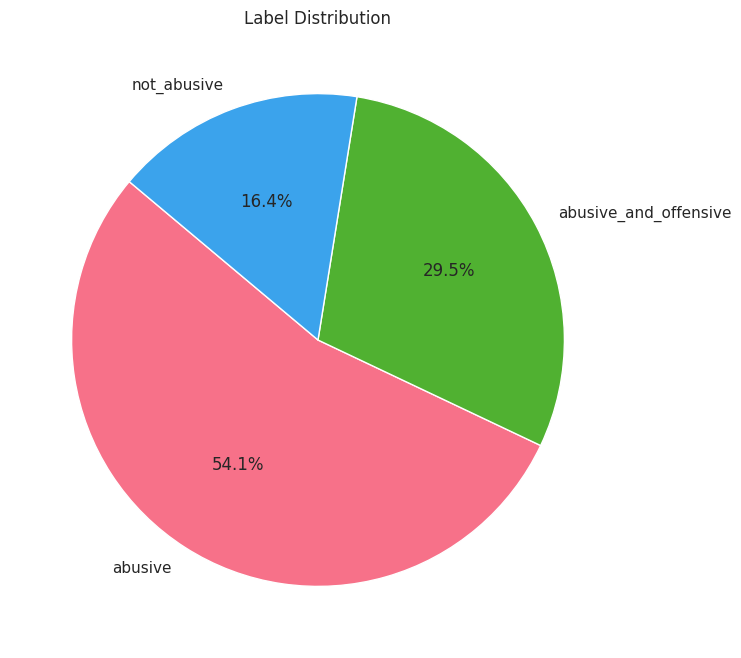

In [ ]:
import matplotlib.pyplot as plt

label_counts = df_cleaned['label'].value_counts()
light_colors = sns.husl_palette(n_colors=len(label_counts))
sns.set(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=light_colors)
plt.title('Label Distribution')
plt.show()

# ekstraksi fitur

In [ ]:
df_cleaned['tweet'] = df_cleaned['tweet'].astype(str).str.lower()

X = df_cleaned['tweet']
y = df_cleaned['label']
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

In [ ]:
from collections import Counter
def top_n_words_per_class(df, label, tweet, n):
    top_n_words = {}
    classes = df_cleaned['label'].unique()

    for class_label in classes:
        # Filter dataframe berdasarkan kelas
        class_df = df_cleaned[df_cleaned['label'] == class_label]

        # Menggabungkan teks dari setiap baris
        combined_text = ' '.join(class_df['tweet'].values)

        # Membagi teks menjadi kata-kata
        words = combined_text.split()

        # Menghitung frekuensi kata-kata
        word_counts = Counter(words)

        # Mengambil top-n most frequent words
        top_n = word_counts.most_common(n)

        # Menyimpan hasil untuk kelas tertentu
        top_n_words[class_label] = top_n

    return top_n_words

# Menggunakan fungsi untuk mengekstrak top-5 most frequent words pada tiap kelas
top_words_per_class = top_n_words_per_class(df, 'label', 'tweet', 5)

# Menampilkan hasil
for class_label, top_words in top_words_per_class.items():
    print(f"Kelas: {class_label}")
    for word, count in top_words:
        print(f"{word}: {count}")
    print()

Kelas: abusive
'f',: 193
'url']: 177
'di',: 154
'yg',: 151
'yang',: 129

Kelas: abusive_and_offensive
'f',: 113
'yg',: 103
'lu',: 85
'di',: 77
'lo',: 75

Kelas: not_abusive
'a']: 97
'f',: 71
'yg',: 70
'dan',: 70
'yang',: 60



# Pemodelan SVM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_augmented, y_train_augmented = smote.fit_resample(X_train, y_train)

In [ ]:
# Inisialisasi scaler
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_augmented)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Hyperparameter tuning
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
linear_svc = SVC(kernel='linear')
clf = GridSearchCV(linear_svc, param_grid, cv=3, scoring='accuracy')
clf.fit(X_train, y_train)
best_svc = clf.best_estimator_

y_pred_test = best_svc.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_test)
print('Model accuracy score with linear kernel and best C:', accuracy)

Model accuracy score with linear kernel and best C: 0.6905940594059405


In [ ]:
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.9504
Test set score: 0.6906


In [ ]:
print(classification_report(y_test, y_pred_test))

                       precision    recall  f1-score   support

              abusive       0.66      0.89      0.76       209
abusive_and_offensive       0.75      0.57      0.65       121
          not_abusive       0.77      0.31      0.44        74

             accuracy                           0.69       404
            macro avg       0.73      0.59      0.62       404
         weighted avg       0.71      0.69      0.67       404

